# Exemple 3 Internet usage série temporelle not seasonal

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
import smtplib

In [3]:
df=pd.read_csv('./WWWusage.csv',names=['values'],header=0)
df.head()

,,values
1,1,88
2,2,84
3,3,85
4,4,85
5,5,84


In [4]:
df.describe()

,values
count,100.000000
mean,137.080000
std,39.999414
min,83.000000
25%,99.000000
50%,138.500000
75%,167.500000
max,228.000000


## Tracé linéaire

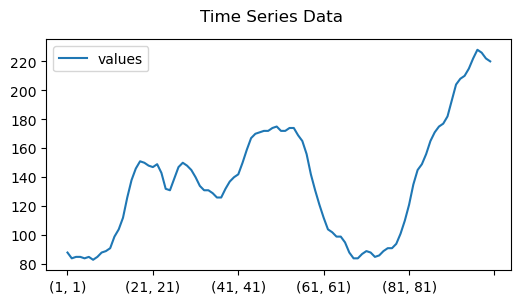

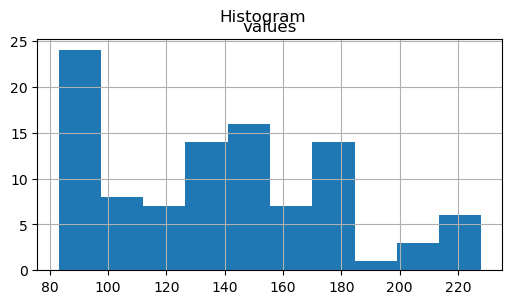

In [6]:
# Line plots of time series
fig, ax = plt.subplots(figsize=(6,3))
fig.suptitle('Time Series Data')
df.plot(ax=ax)
plt.show()
#Historgram
fig, ax = plt.subplots(figsize=(6,3))
fig.suptitle('Histogram')
df.hist(ax=ax)
plt.show()

d'après les tracé ci-dessus, la série ne parait pas seasonal

## CHOISIR LES PARAMETRES ARIMA

### Autocorrelation

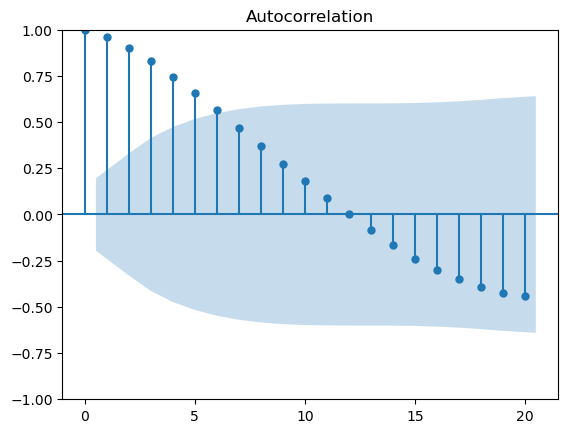

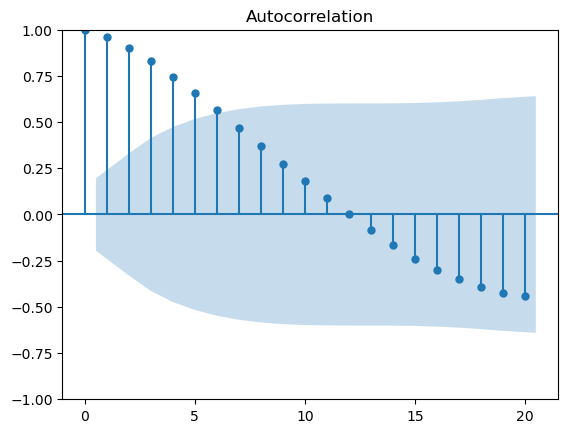

In [7]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df.values)

De toute évidence, les données ne sont pas idéales pour que le modèle ARIMA démarre directement l'entraînement autorégressif. Voyons donc comment le segment de différenciation d'ARIMA rend les données stationnaires.

### Différenciation du premier ordre
À partir du graphique d'autocorrélation, nous pouvons décider si davantage de différenciation est nécessaire. Si, collectivement, les autocorrélations, ou le point de données de chaque décalage (sur l'axe horizontal), sont positifs pour plusieurs décalages consécutifs, une différenciation supplémentaire peut être nécessaire. Inversement, si plus de points de données sont négatifs, la série est sur-différentiée.

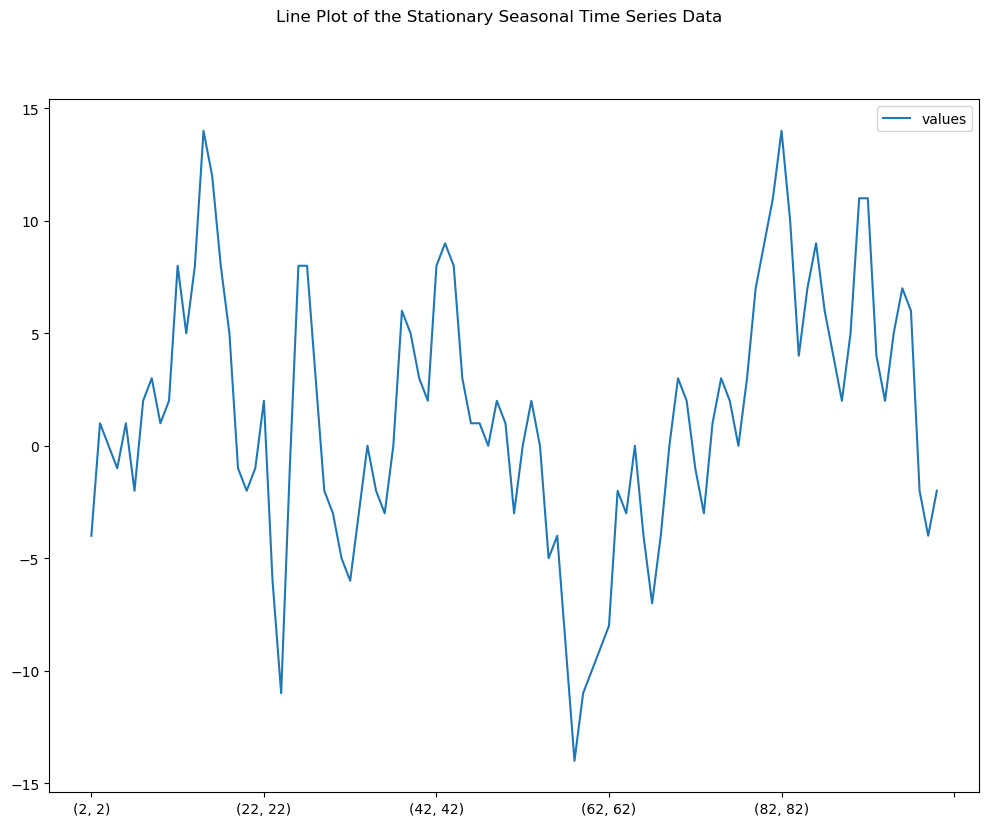

In [14]:
from statsmodels.graphics.tsaplots import plot_pacf
#time_series=time_series.set_index('Month')
df_diff = df.diff()
df_diff.dropna(inplace=True)
# Plot differenced data
fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle('Line Plot of the Stationary Seasonal Time Series Data')
df_diff.plot(ax=ax)
plt.show()


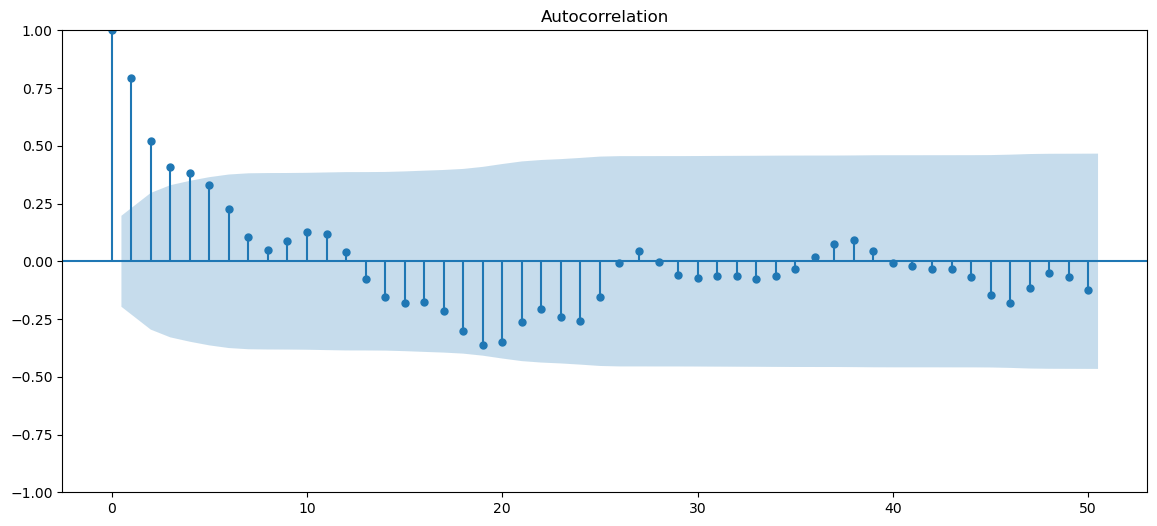

In [18]:
fig, ax1 = plt.subplots(figsize=(14,6))
ax1 = plot_acf(x=df_diff, lags=50, ax=ax1)
plt.show()

C:\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


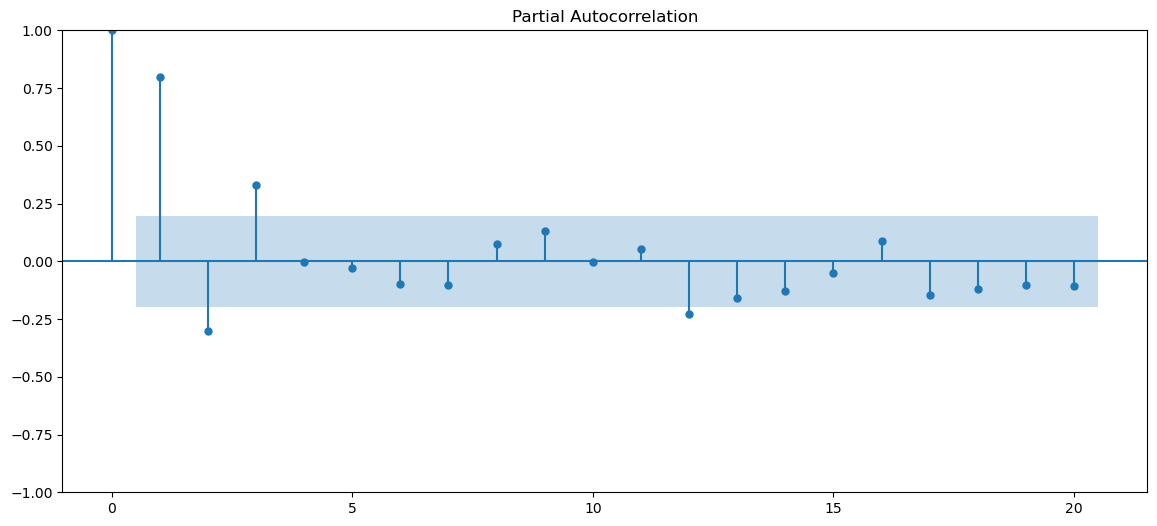

In [30]:
from statsmodels.graphics.tsaplots import plot_pacf
fig, ax1 = plt.subplots(figsize=(14,6))
ax1 = plot_pacf(x=df_diff, ax=ax1)
plt.show()

### Différenciation du deuxième ordre

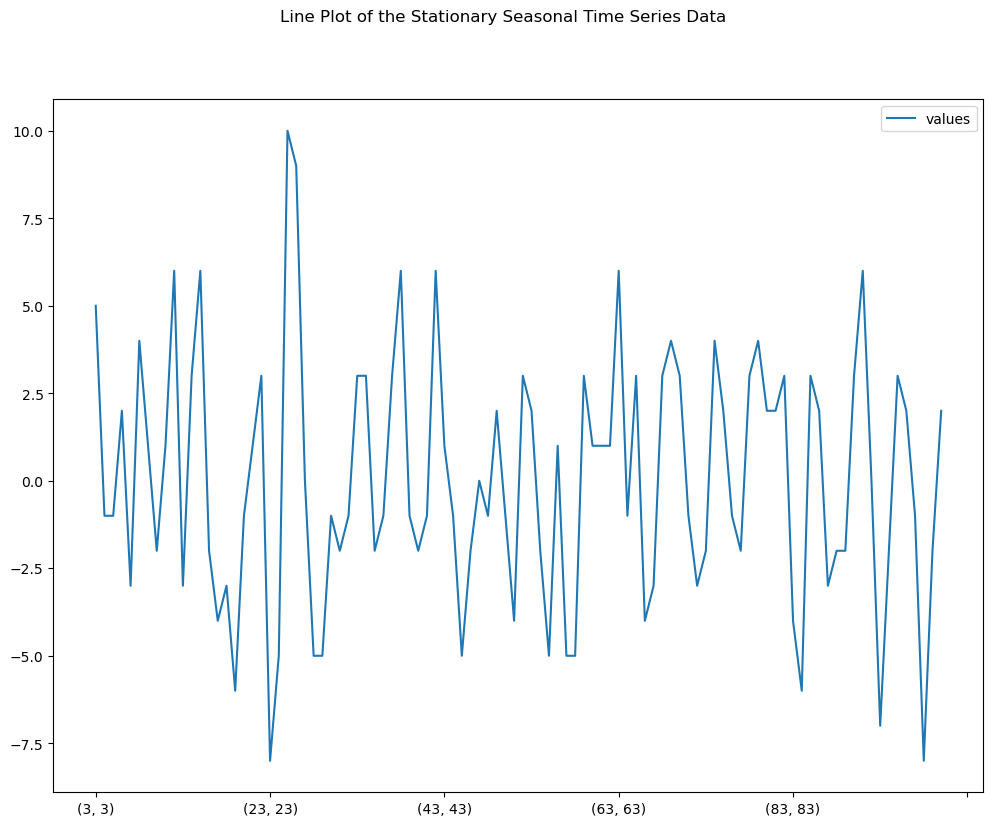

In [20]:
#time_series=time_series.set_index('Month')
df_diff2 = df.diff().diff()
df_diff2.dropna(inplace=True)
# Plot differenced data
fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle('Line Plot of the Stationary Seasonal Time Series Data')
df_diff2.plot(ax=ax)
plt.show()


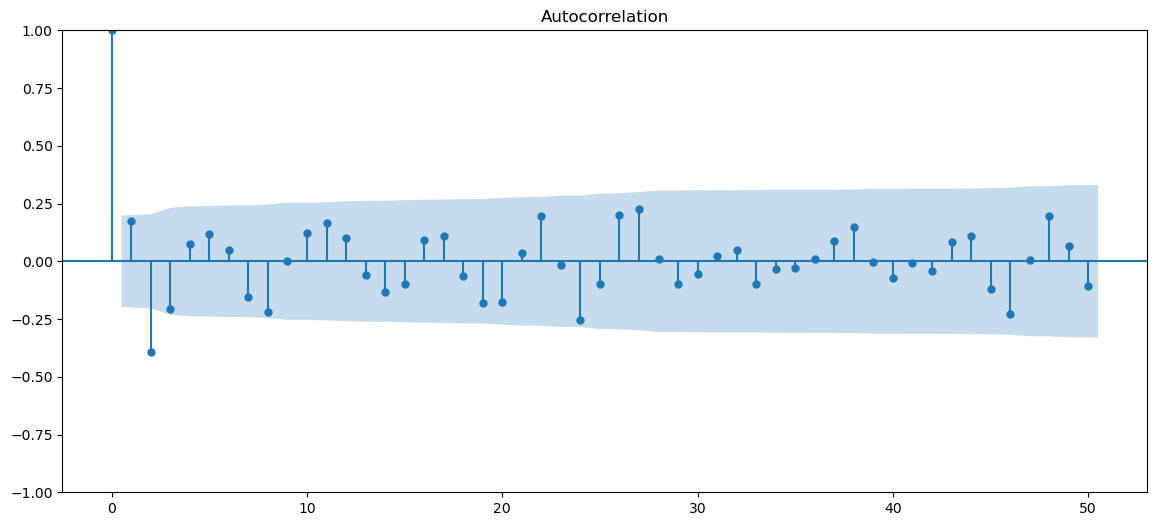

In [21]:
fig, ax1 = plt.subplots(figsize=(14,6))
ax1 = plot_acf(x=df_diff2, lags=50, ax=ax1)
plt.show()


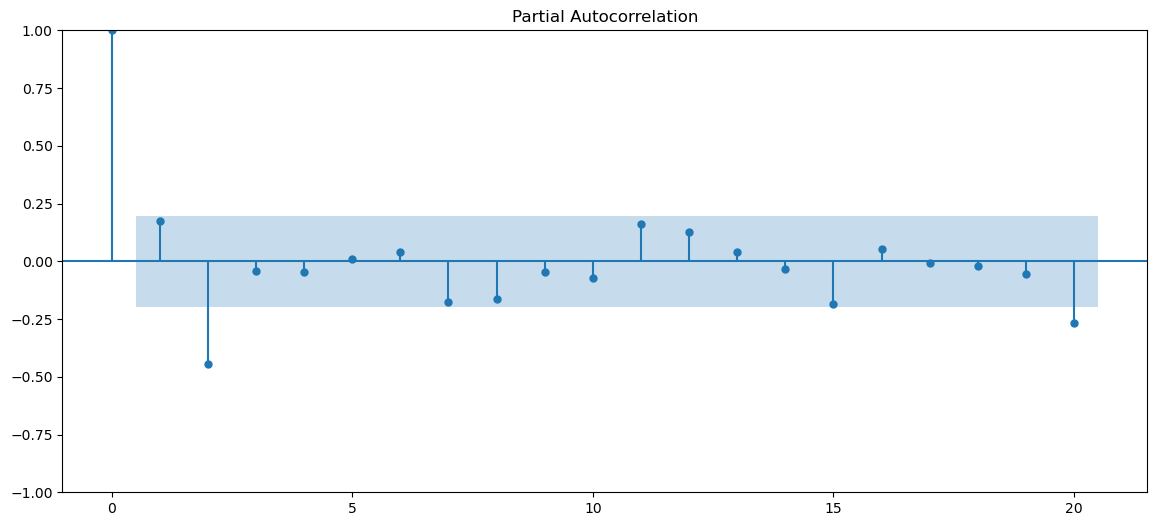

In [31]:
from statsmodels.graphics.tsaplots import plot_pacf
fig, ax1 = plt.subplots(figsize=(14,6))
ax1 = plot_pacf(x=df_diff2, ax=ax1)
plt.show()

### Test de Dickey Fuller
Cependant, un test plus mathématique peut être utilisé pour déterminer quel ordre est le meilleur pour les données en question. Le test Dickey-Fuller augmenté est l'une de ces mesures que statsmodel fournit facilement. Le test ADF vise à rejeter l'hypothèse nulle selon laquelle les données de séries chronologiques données ne sont pas stationnaires. Il calcule la valeur de p et la compare à une valeur seuil ou à un niveau de signification de 0,05. Si la valeur p est inférieure à ce niveau, les données sont stationnaires ; sinon, l'ordre de différenciation est incrémenté de un.

In [28]:
from statsmodels.tsa.stattools import adfuller
result= adfuller(df['values'].dropna())
print('p-value',result[1])
result= adfuller(df['values'].diff().dropna())
print('p-value',result[1])
result= adfuller(df['values'].diff().diff().dropna())
print('p-value',result[1])

p-value 0.1244193544710952
p-value 0.07026846015272693
p-value 2.843428755547158e-17


Comme nous le voyons ci-dessus, après la différenciation du 2e ordre, la valeur de p chute au-delà du seuil acceptable. Ainsi, nous pouvons considérer l'ordre de différenciation ("d") comme 2. Cela correspond bien au graphique linéaire d'autocorrélation vu ci-dessus. Cependant, la valeur de p pour le 1er ordre est beaucoup plus proche du seuil, donc pour être prudent, nous considérerons "d" comme 1 et verrons comment le modèle fonctionne.
a prochaine étape du modèle ARIMA consiste à calculer « p », ou l'ordre du modèle autorégressif. Nous pouvons inspecter le graphique d'autocorrélation partielle, qui mesure la corrélation entre les données de la série chronologique et un certain décalage. Sur la base de la présence ou de l'absence de corrélation, nous pouvons déterminer si le décalage ou l'ordre est nécessaire ou non.
Enfin, « q » peut être estimé de manière similaire en examinant le tracé ACF au lieu du tracé PACF. En regardant le nombre de décalages franchissant le seuil, nous pouvons déterminer quelle part du passé serait suffisamment importante pour être prise en compte pour l'avenir. Ceux qui ont une corrélation élevée contribuent davantage et suffiraient à prédire les valeurs futures. À partir des graphiques ci-dessus, le paramètre de moyenne mobile (MA) peut être défini sur 2.

Ainsi, notre modèle ARIMA final peut être défini comme ARIMA(p=1, d=1,q= 2).

## Fit ARIMA model

In [75]:
from statsmodels.tsa.arima.model import ARIMA
arima_model=ARIMA(df.values,order=(1,1,2))
model=arima_model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -254.126
Date:                Sun, 08 Jan 2023   AIC                            516.253
Time:                        13:25:29   BIC                            526.633
Sample:                             0   HQIC                           520.453
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6976      0.130      5.365      0.000       0.443       0.952
ma.L1          0.4551      0.169      2.699      0.007       0.125       0.786
ma.L2         -0.0664      0.157     -0.424      0.6

#### Interpréter les résultats
Comme vu ci-dessus, le résumé du modèle fournit plusieurs mesures statistiques pour évaluer les performances de notre modèle. De plus, nous connaissons également les valeurs des coefficients pour chacun des paramètres. Comme nous avons conservé la valeur du paramètre MA ou "q" à 2, nous avons deux coefficients entraînés pour MA et un pour AR.

En dehors de cela, nous voyons les scores tels que les critères d'information d'Akaike (AIC), le critère d'information bayésien (BIC), le critère d'information de Hannan-Quinn (HQIC) et l'écart type des innovations (les innovations sont la différence de la valeur réelle au temps t et la valeur prédite à ce moment-là).

## Minimiser AIC
Les critères d'information d'Akaike ou AIC sont une bonne mesure pour tester la qualité de l'ajustement mathématique du modèle. Les scores des critères d'information mesurent la quantité d'informations perdues lors de la formation et de la généralisation du modèle ARIMA. L'AIC doit être le plus faible possible. En affichant le résumé du modèle du modèle ARIMA formé à partir de statsmodel, nous pouvons vérifier les scores AIC et d'autres mesures de performances statistiques.

In [76]:
import pmdarima as pm
model = pm.auto_arima(df['values'], d=1, D=1,seasonal=True, m=12, trend='c',start_p=0, start_q=0, max_order=6, test='adf', stepwise=True, trace=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.80 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=613.455, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=516.574, Time=0.23 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=513.965, Time=0.38 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=539.343, Time=0.15 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.89 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=1.25 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=531.510, Time=0.32 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.85 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.48 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=482.842, Time=0.40 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=507.195, Time=0.14 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=1.25 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=inf, Time=1.66 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=501.710, Time=0.32

In [79]:
arima_model=ARIMA(df.values[:80],order=(0,1,1))
model=arima_model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   80
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -215.225
Date:                Sun, 08 Jan 2023   AIC                            434.450
Time:                        14:45:49   BIC                            439.189
Sample:                             0   HQIC                           436.349
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.7632      0.065     11.816      0.000       0.637       0.890
sigma2        13.4606      2.207      6.099      0.000       9.135      17.786
Ljung-Box (L1) (Q):                  11.88   Jarque-

C:\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [97]:
y_pred=pd.Series(model.forecast(20)[0],index=df['values'][80:].index)
y_true=df['values'][80:]
mape=np.mean(np.abs(y_pred-y_true)/np.abs(y_true))
mae=np.mean(np.abs(y_pred-y_true))
mpe=np.mean((y_pred-y_true)/y_true)
rmse=np.mean((y_pred-y_true)**2)**0.5

import pprint
pprint.pprint({'mape':mape,
              'mae':mae,
              'mpe':mpe,
              'rmse':rmse,
              })

{'mae': 71.79347697284467,
 'mape': 0.3643205719578229,
 'mpe': -0.3643205719578229,
 'rmse': 78.78174494037549}
